In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

y_pred = np.load("/home/bbapi/data_splits/y_test_pred_linear.npy")
y_test = np.load("/home/bbapi/data_splits/y_test.npy")

y_pred_np = y_pred.cpu().numpy() if torch.is_tensor(y_pred) else y_pred

# y_test is likely still a pandas Series or NumPy array
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

# Avoid division by zero
epsilon = 1e-8
response = y_test_np.flatten() / (y_pred_np.flatten() + epsilon)

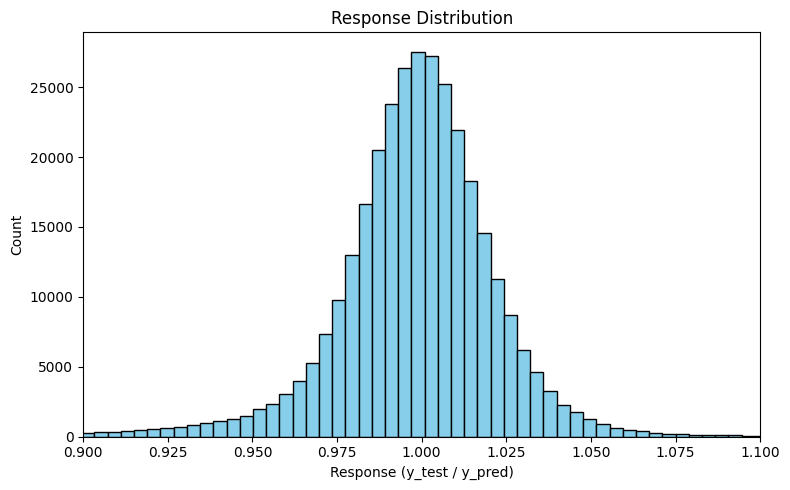

In [2]:
plt.figure(figsize=(8, 5))
plt.hist(response, bins=10000, color='skyblue', edgecolor='black')
plt.xlabel('Response (y_test / y_pred)')
plt.ylabel('Count')
plt.xlim(0.9, 1.1)
plt.title('Response Distribution')
plt.tight_layout()
plt.show()

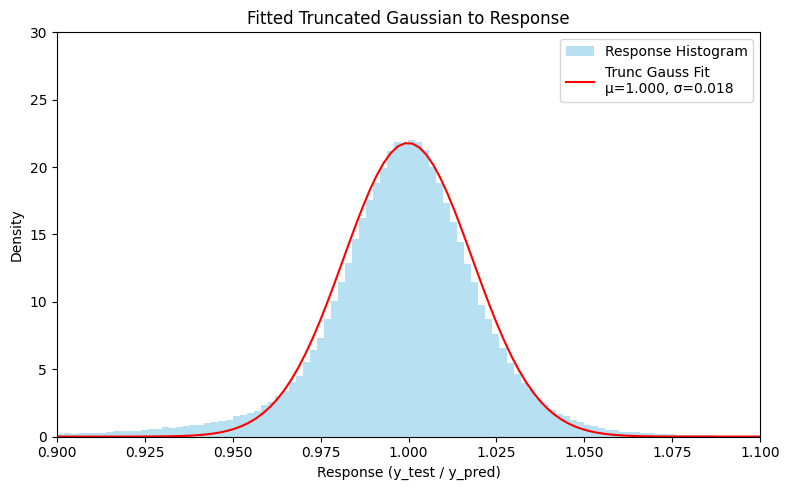

In [4]:
epsilon = 1e-8
response = y_test_np.flatten() / (y_pred_np.flatten() + epsilon)

# Optionally: restrict to reasonable range (truncate manually)
response = response[(response > 0.9) & (response < 1.1)]  # or whatever makes sense

def truncated_gaussian(x, mu, sigma, a, b):
    # a and b are bounds in standard normal units
    a_scaled = (a - mu) / sigma
    b_scaled = (b - mu) / sigma
    return truncnorm.pdf(x, a_scaled, b_scaled, loc=mu, scale=sigma)

from scipy.stats import truncnorm
from scipy.optimize import curve_fit
counts, bin_edges = np.histogram(response, bins=1000, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Fit
popt, _ = curve_fit(
    lambda x, mu, sigma: truncated_gaussian(x, mu, sigma, a=0.9, b=1.1),
    bin_centers, counts, p0=[1.0, 0.1]
)
mu_fit, sigma_fit = popt

x_vals = np.linspace(0.9, 1.1, 100)
pdf_vals = truncated_gaussian(x_vals, mu_fit, sigma_fit, a=0.5, b=1.5)

plt.figure(figsize=(8, 5))
plt.hist(response, bins=100, density=True, color='skyblue', alpha=0.6, label='Response Histogram')
plt.plot(x_vals, pdf_vals, 'r-', label=f'Trunc Gauss Fit\nμ={mu_fit:.3f}, σ={sigma_fit:.3f}')
plt.xlabel('Response (y_test / y_pred)')
plt.xlim(0.9, 1.1)
plt.ylim(0, 30)
plt.ylabel('Density')
plt.title('Fitted Truncated Gaussian to Response')
plt.legend()
plt.tight_layout()
plt.show()

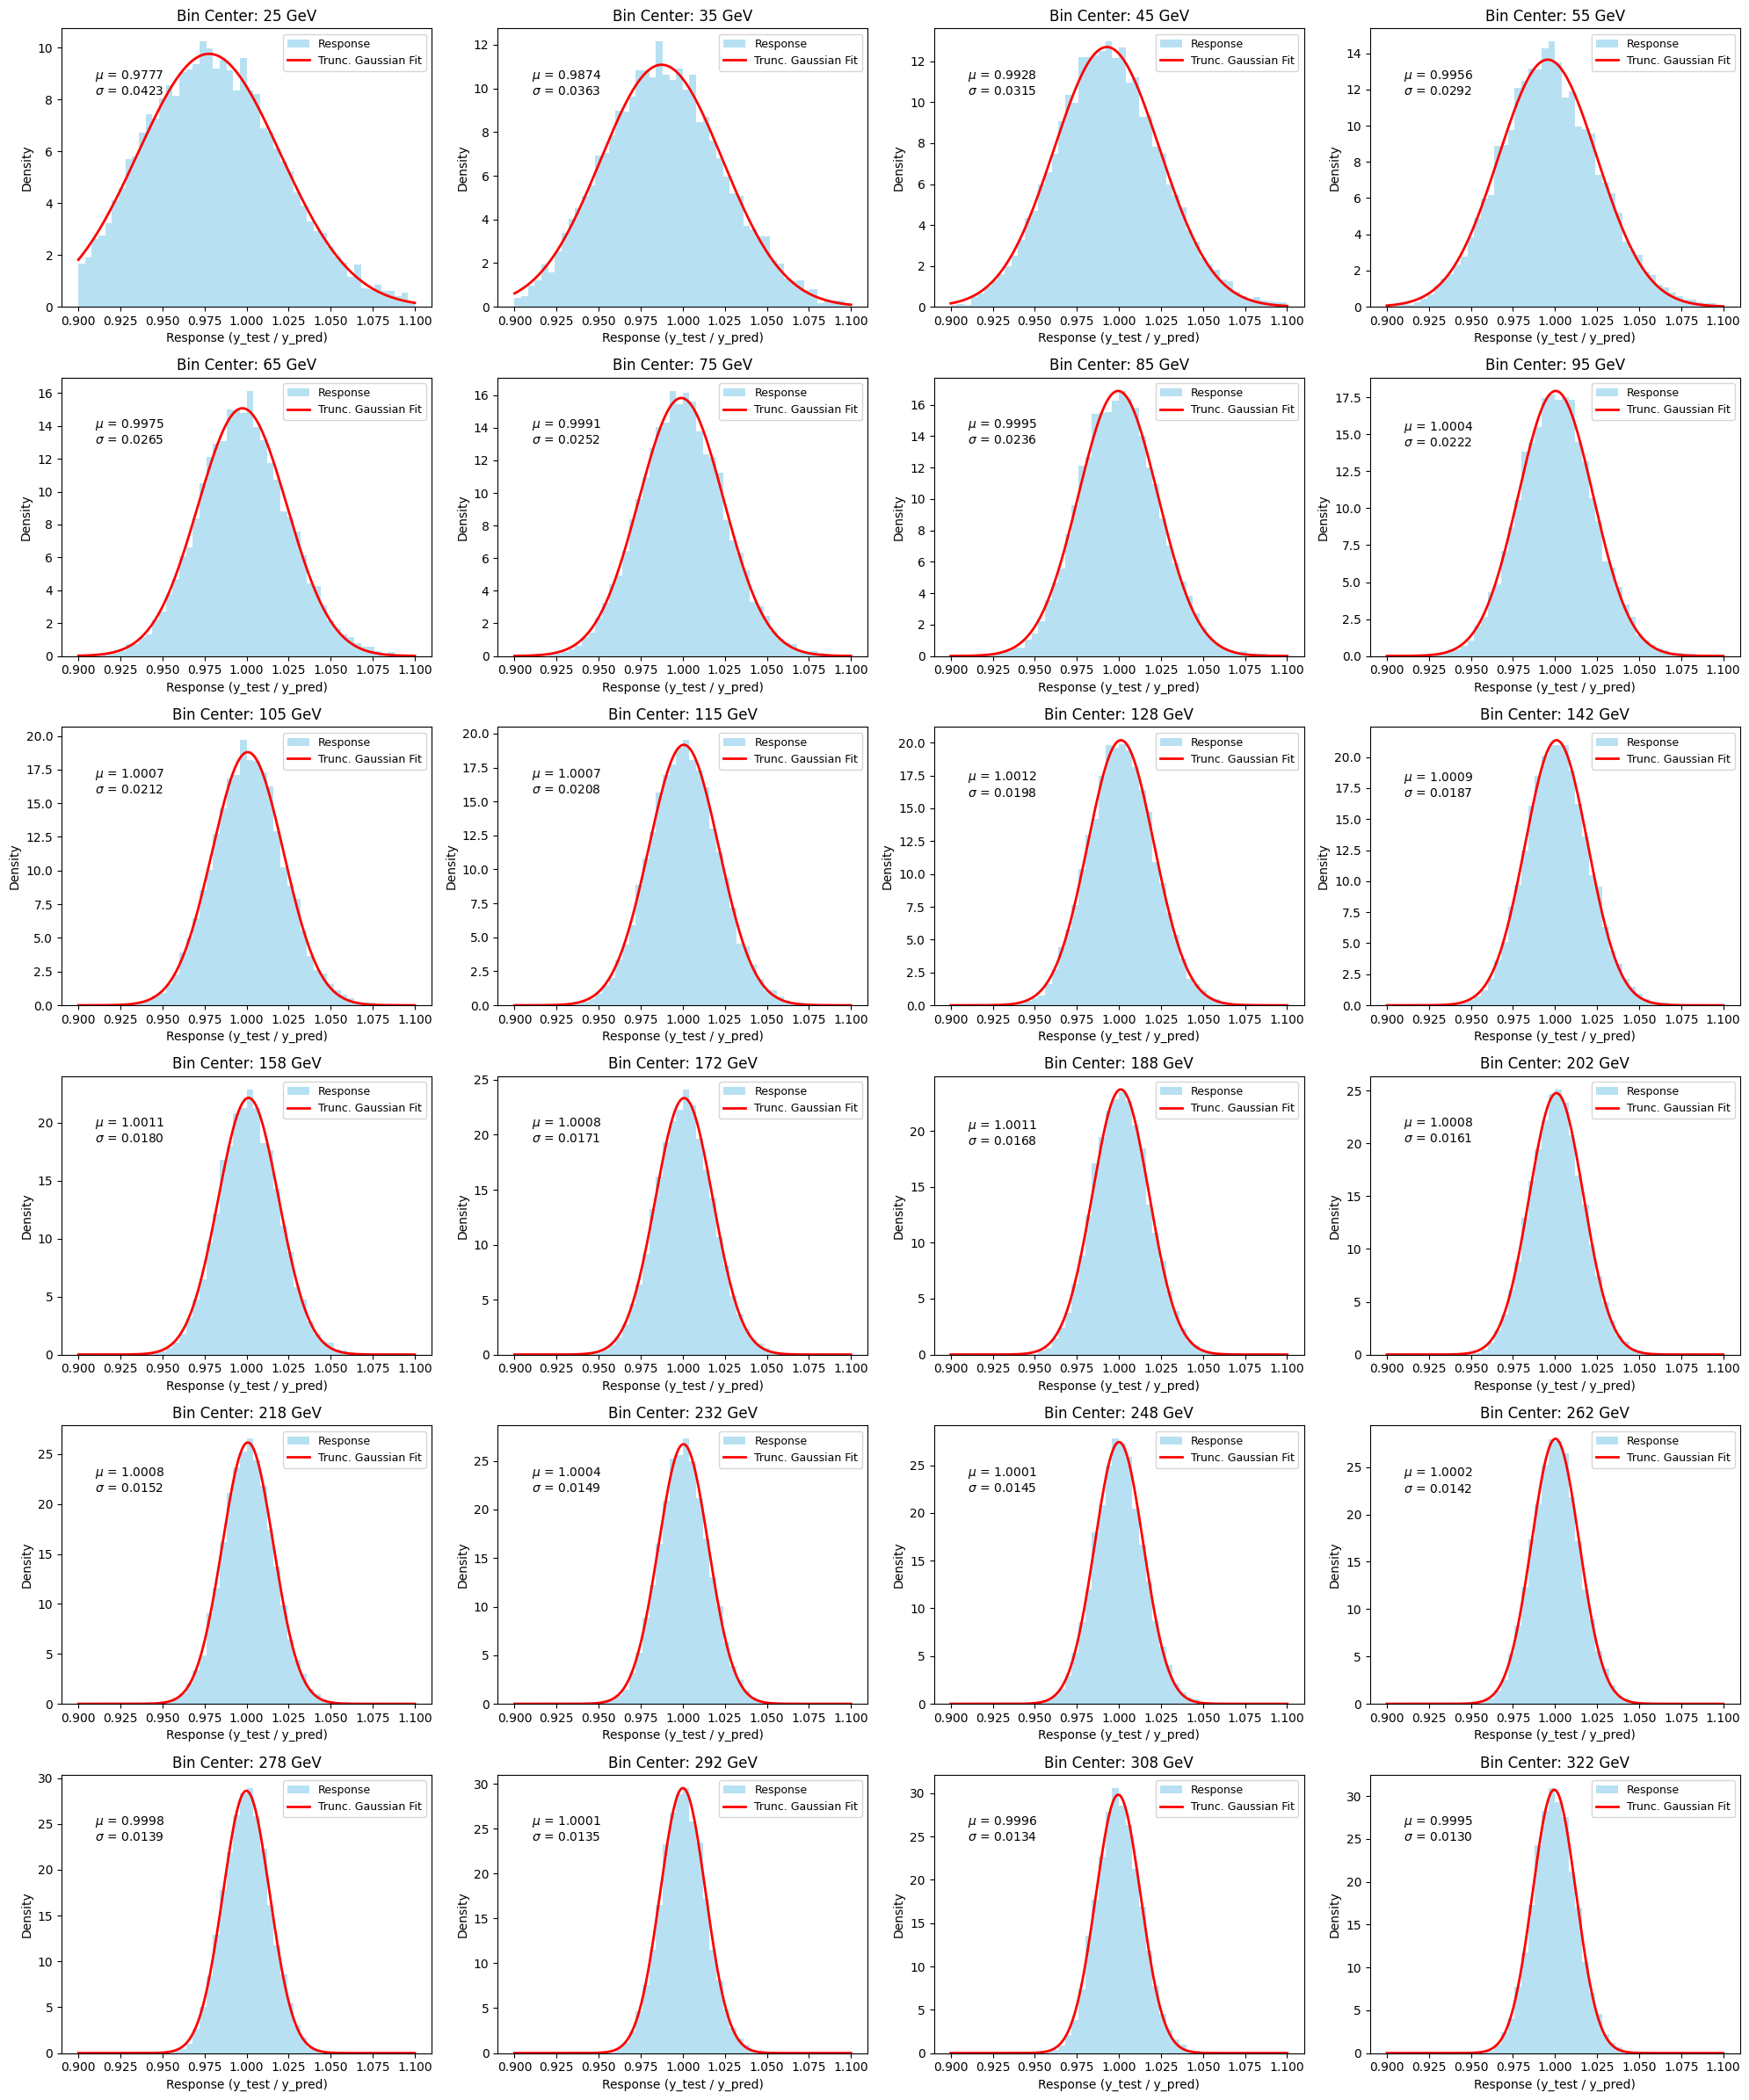

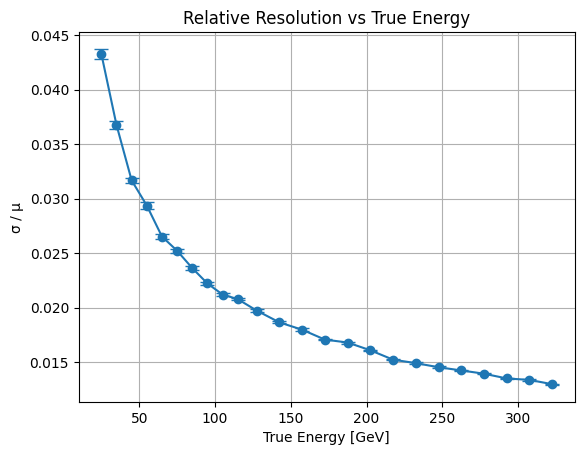

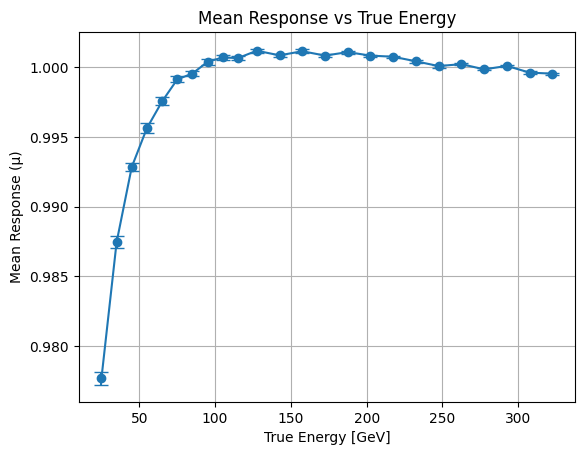

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.optimize import curve_fit

# Truncated Gaussian PDF
def truncated_gaussian(x, mu, sigma, a=0.9, b=1.1):
    a_, b_ = (a - mu) / sigma, (b - mu) / sigma
    return truncnorm.pdf(x, a_, b_, loc=mu, scale=sigma)

# Fit wrapper
def fit_func(x, mu, sigma):
    return truncated_gaussian(x, mu, sigma)

# Step 1: Prepare data
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_np = y_pred
y_test_np = y_test_np.flatten()
y_pred_np = y_pred_np.flatten()

# Step 2: Binning based on y_test
# bin_edges = np.arange(0, y_test_np.max()+10 , 10)


# bin_edges = np.arange(5, y_test_np.max() + 10, 10)

bin_edges = np.concatenate([
    np.arange(20, 120, 10),     # finer bins: 20, 25, 30, ..., 95
    np.arange(120, y_test_np.max() + 20, 15)  # coarser bins beyond 100 GeV
])

bin_edges = bin_edges[:-2]

bin_indices = np.digitize(y_test_np, bin_edges)

# Step 3: Containers
response_bins = []
bin_centers = []
mu_vals, sigma_vals, mu_errs, sigma_errs = [], [], [], []
epsilon = 1e-8

# Step 4: Fit truncated Gaussian per bin
for i in range(1, len(bin_edges)):
    indices = np.where(bin_indices == i)[0]
    if len(indices) < 10:
        continue

    y_test_bin = y_test_np[indices]
    y_pred_bin = y_pred_np[indices]
    response = y_test_bin / (y_pred_bin + epsilon)
    response_bins.append(response)
    center = (bin_edges[i - 1] + bin_edges[i]) / 2
    bin_centers.append(center)

    hist_vals, bin_edges_hist = np.histogram(response, bins=50, range=(0.9, 1.1), density=True)
    bin_centers_hist = 0.5 * (bin_edges_hist[1:] + bin_edges_hist[:-1])
    mu_guess = np.mean(response)
    sigma_guess = np.std(response)

    try:
        popt, pcov = curve_fit(fit_func, bin_centers_hist, hist_vals, p0=[mu_guess, sigma_guess])
        mu_fit, sigma_fit = popt
        mu_vals.append(mu_fit)
        sigma_vals.append(sigma_fit)
        mu_errs.append(np.sqrt(pcov[0, 0]))
        sigma_errs.append(np.sqrt(pcov[1, 1]))
    except Exception as e:
        print(f"Fit failed for bin {i}: {e}")
        continue

# Step 5: Plot all fits with tight layout
n_plots = len(response_bins)
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten() if n_plots > 1 else [axs]

for plot_idx in range(n_plots):
    ax = axs[plot_idx]
    response = response_bins[plot_idx]
    center = bin_centers[plot_idx]
    mu_fit = mu_vals[plot_idx]
    sigma_fit = sigma_vals[plot_idx]

    hist_vals, bin_edges_hist = np.histogram(response, bins=50, range=(0.9, 1.1), density=True)
    bin_centers_hist = 0.5 * (bin_edges_hist[1:] + bin_edges_hist[:-1])
    x_fit = np.linspace(0.9, 1.1, 200)

    ax.hist(response, bins=50, range=(0.9, 1.1), density=True, alpha=0.6, color='skyblue', label='Response')
    ax.plot(x_fit, truncated_gaussian(x_fit, mu_fit, sigma_fit), 'r-', lw=2, label='Trunc. Gaussian Fit')
    ax.set_title(f'Bin Center: {center:.0f} GeV')
    ax.set_xlabel("Response (y_test / y_pred)")
    ax.set_ylabel("Density")
    ax.text(0.91, np.max(hist_vals) * 0.8, f"$\\mu$ = {mu_fit:.4f}\n$\\sigma$ = {sigma_fit:.4f}", fontsize=10)
    ax.legend(fontsize=9)

# Hide unused subplots
for j in range(n_plots, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

# Step 6: Summary plots

# Convert lists to arrays
mu_vals = np.array(mu_vals)
sigma_vals = np.array(sigma_vals)
mu_errs = np.array(mu_errs)
sigma_errs = np.array(sigma_errs)
bin_centers = np.array(bin_centers)

# Calculate σ/μ and its uncertainty
sigma_over_mu = sigma_vals / mu_vals
sigma_over_mu_err = sigma_over_mu * np.sqrt((sigma_errs / sigma_vals)**2 + (mu_errs / mu_vals)**2)

# Plot σ/μ
plt.errorbar(bin_centers, sigma_over_mu, yerr=sigma_over_mu_err, fmt='o-', capsize=5)
plt.xlabel("True Energy [GeV]")
plt.ylabel("σ / μ")
plt.title("Relative Resolution vs True Energy")
plt.grid(True)
plt.show()

# Plot μ
plt.errorbar(bin_centers, mu_vals, yerr=mu_errs, fmt='o-', capsize=5)
plt.xlabel("True Energy [GeV]")
plt.ylabel("Mean Response (μ)")
plt.title("Mean Response vs True Energy")
plt.grid(True)
plt.show()

Stochastic term (S): 0.2129 ± 0.0007
Constant term (C):   0.0055 ± 0.0001


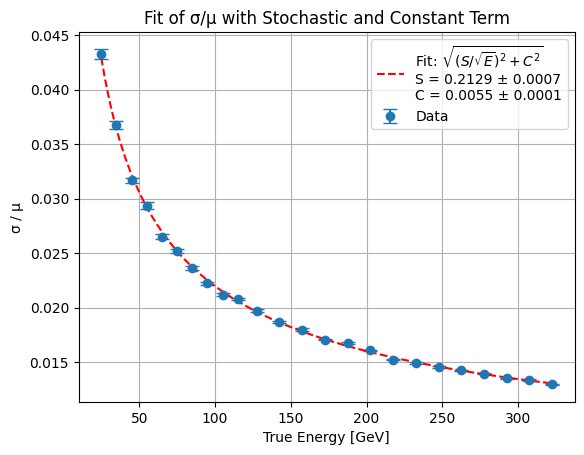

In [6]:
# Define fit function: sqrt( (S/sqrt(E))^2 + C^2 )
def resolution_model(E, S, C):
    return np.sqrt((S / np.sqrt(E))**2 + C**2)

# Initial guess: S = 0.3, C = 0.01
popt, pcov = curve_fit(resolution_model, bin_centers, sigma_over_mu,
                       sigma=sigma_over_mu_err, p0=[0.3, 0.01], absolute_sigma=True)

S_fit, C_fit = popt
S_err, C_err = np.sqrt(np.diag(pcov))

# Print results
print(f"Stochastic term (S): {S_fit:.4f} ± {S_err:.4f}")
print(f"Constant term (C):   {C_fit:.4f} ± {C_err:.4f}")

# Plot the fit over the data
E_plot = np.linspace(min(bin_centers), max(bin_centers), 300)
fit_curve = resolution_model(E_plot, S_fit, C_fit)

plt.errorbar(bin_centers, sigma_over_mu, yerr=sigma_over_mu_err, fmt='o', capsize=5, label='Data')
plt.plot(E_plot, fit_curve, 'r--', label=f'Fit: $\\sqrt{{(S/\\sqrt{{E}})^2 + C^2}}$\nS = {S_fit:.4f} ± {S_err:.4f}\nC = {C_fit:.4f} ± {C_err:.4f}')
plt.xlabel("True Energy [GeV]")
plt.ylabel("σ / μ")
plt.title("Fit of σ/μ with Stochastic and Constant Term")
plt.grid(True)
plt.legend()
plt.show()